# Self-Driving Car Engineer Nanodegree

## Deep Learning

### Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

# Load the training, validation and testing data
training_file = 'assets/data/train.p'
validation_file='assets/data/valid.p'
testing_file = 'assets/data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# keep copy of original training data
X_train_orig = list(X_train)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Summary of the Data Set Using Python and Numpy

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
# extract: height, width, but not the channels using [:2]
image_shape = X_train[0].shape[:2]

# How many unique classes/labels there are in the dataset.
# Returns the indices of the 1st occurrences of the unique values in the original array
# Returns the number of times each unique value comes up in the original array
classes, indices, unique_counts = np.unique(y_train, return_index=True, return_counts=True)
n_classes = len(classes)

valid_classes, valid_unique_counts = np.unique(y_valid, return_counts=True)
test_classes, test_unique_counts = np.unique(y_test, return_counts=True)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Number of times unique index 1 comes up in input array = ", unique_counts[1])

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
Number of times unique index 1 comes up in input array =  1980


### Include an exploratory visualization of the dataset

### Visualize signnames.csv as a Pandas DataFrame Table

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import csv
# Visualizations will be shown in the notebook.
%matplotlib inline

# extract class ID: sign name as key:value pair into dictionary
sign_dict = {}
with open("assets/data/signnames.csv") as signnames_file:
    reader = csv.reader(signnames_file)
    # Skip the first row of the csv file
    next(reader)    
    for rows in reader:
        sign_dict[int(rows[0])] = rows[1]

dfTrafficSignNames = pd.DataFrame(sign_dict.items(), columns=["ClassId", "Sign-Name"])
dfTrafficSignNames.style.hide_index()

### Visualize German Traffic Sign Types as a Gallery

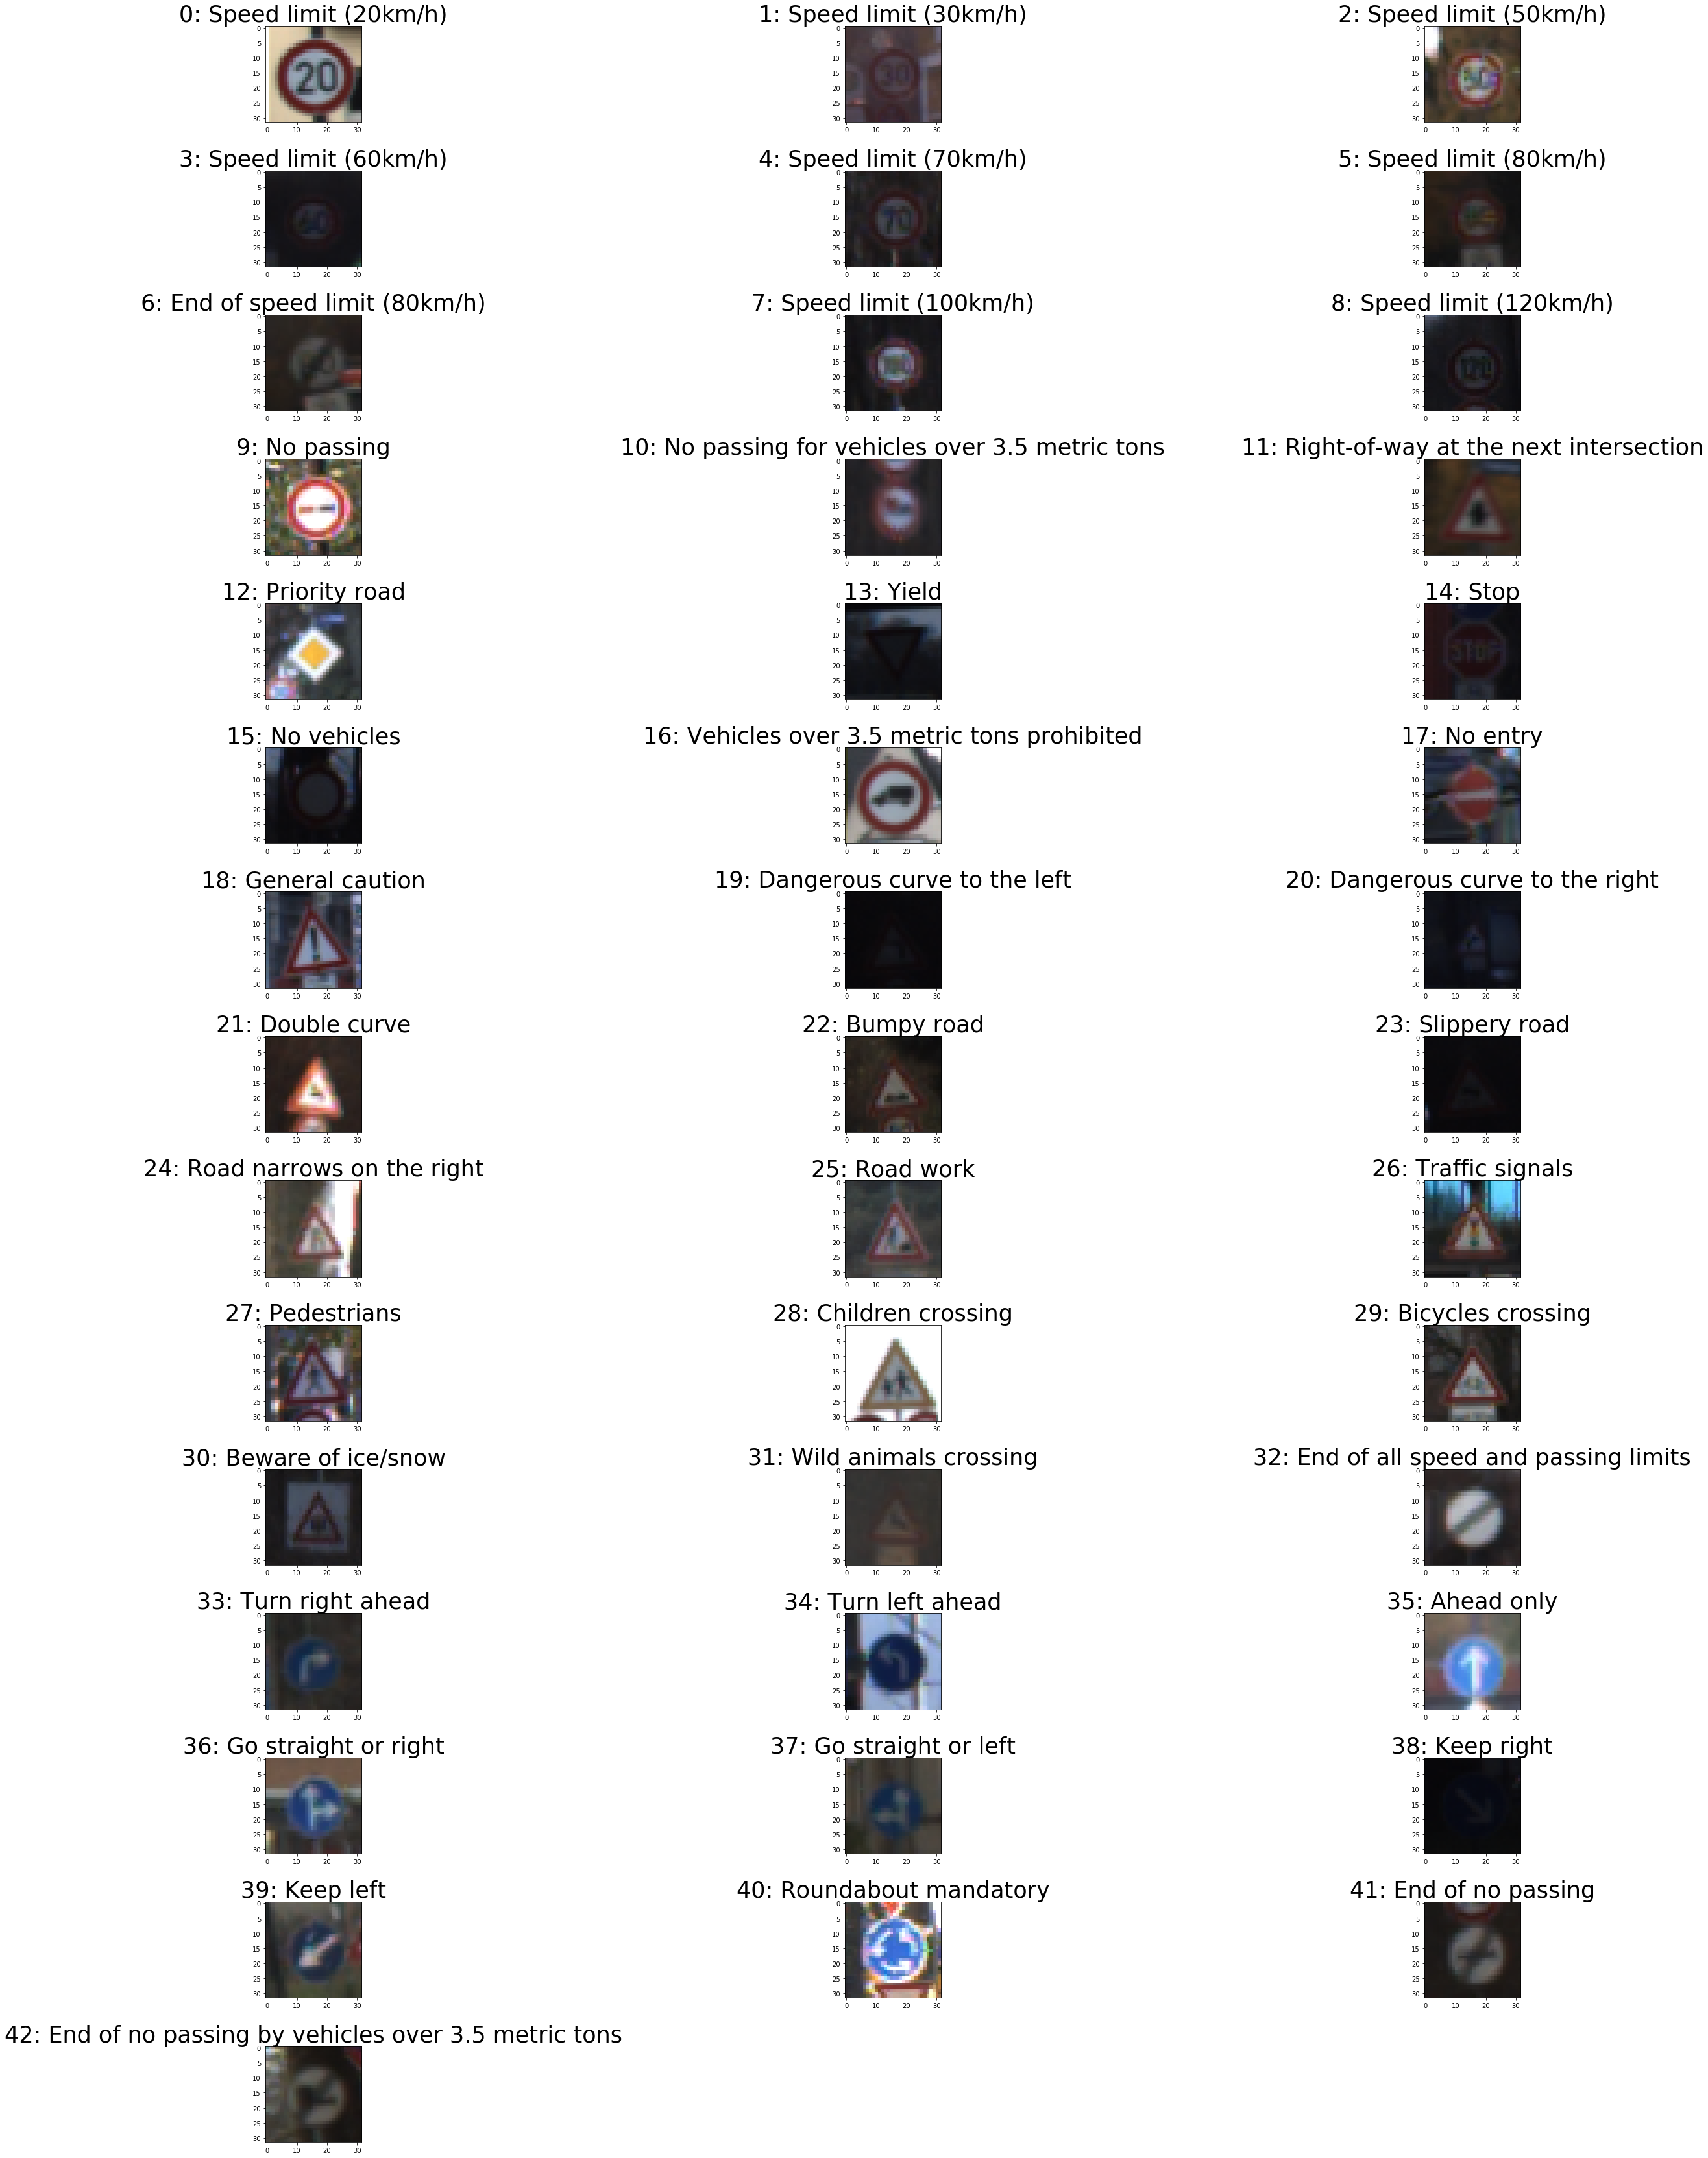

In [4]:
# seet the figure size to be width = 40, height = 60 inches
fig = plt.figure(figsize=(40,60))
# set the width space between subplots = 1, set the height space between subplots = 0.5
fig.subplots_adjust(hspace = 0.5, wspace = 1)
# set the subplot to have 15 rows and 3 columns
nrows = math.ceil(n_classes/3) # 15 rows
ncols = math.ceil(n_classes/15) # 3 columns
# Display Image Gallery shows a nice distribution of images with titles
for i in range(n_classes):
    # specify subplot index (i+1) as place to plot image in figure
    sub = fig.add_subplot(nrows, ncols, i + 1)
    image = X_train[indices[i]]
    # set the title for the subplot
    title = "{}: {}".format(i, sign_dict[i])
    sub.set_title(title, size=35)
    # plot the image in the subplot
    sub.imshow(image, interpolation = 'nearest')

### Visualize the Distribution of Traffic Signs in the Training Set

Display the count of each traffic sign type in a bar graph. Is the distribution the same? Are there more examples of some classes (traffic sign types) than others?

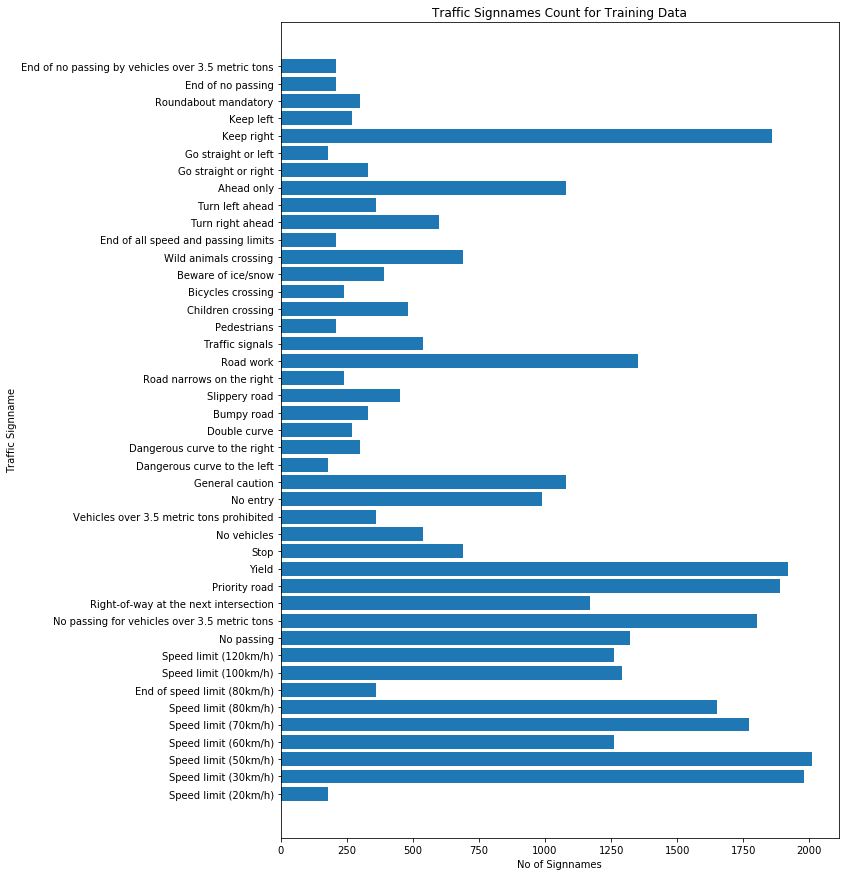

In [5]:
# 2. Display Distribution of the Data in Bar Graph(Train Dataset Sign Counts)
# Each bar is a unique traffic sign with the count of occurences of that sign
plt.figure(figsize=(10,15))
plt.barh(classes, unique_counts)
plt.xlabel('No of Signnames', fontsize=10)
plt.ylabel('Traffic Signname', fontsize=10)
plt.yticks(classes, sign_dict.values(), fontsize=10)
plt.title('Traffic Signnames Count for Training Data')
plt.show()

### Visualize the Distribution of Traffic Signs in the Validation Set

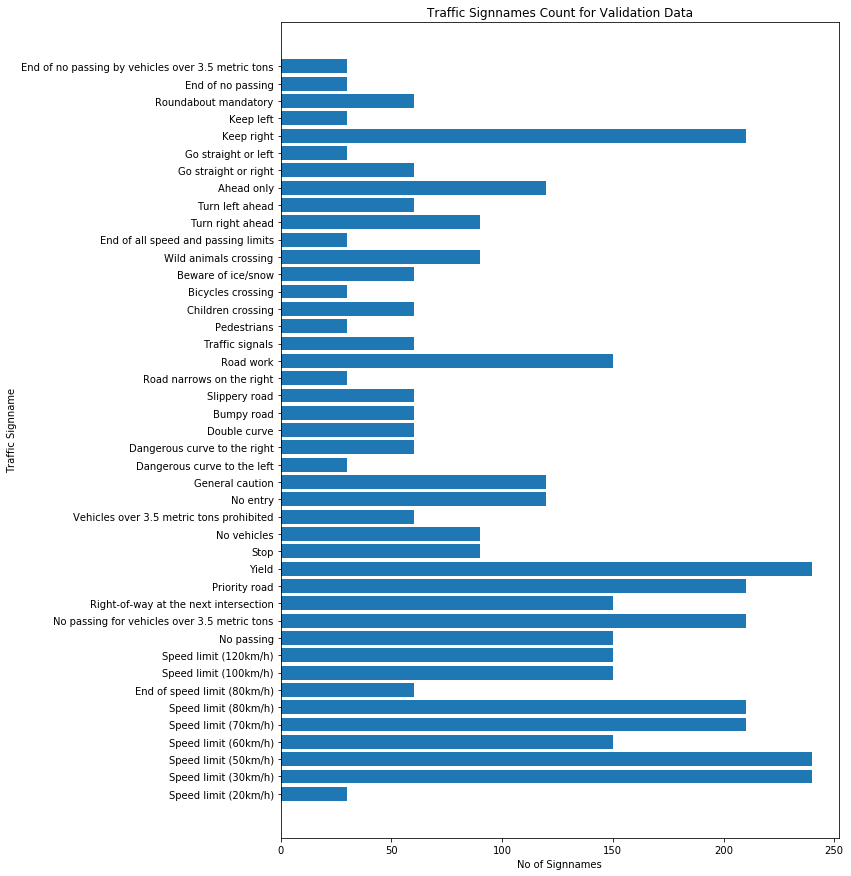

In [6]:
# 3. Display Valid Dataset Sign Counts in Distribution Bar Graph
plt.figure(figsize=(10,15))
plt.barh(classes, valid_unique_counts)
plt.xlabel('No of Signnames', fontsize=10)
plt.ylabel('Traffic Signname', fontsize=10)
plt.yticks(classes, sign_dict.values(), fontsize=10)
plt.title('Traffic Signnames Count for Validation Data')
plt.show()

### Visualize the Distribution of Traffic Signs in the Testing Set

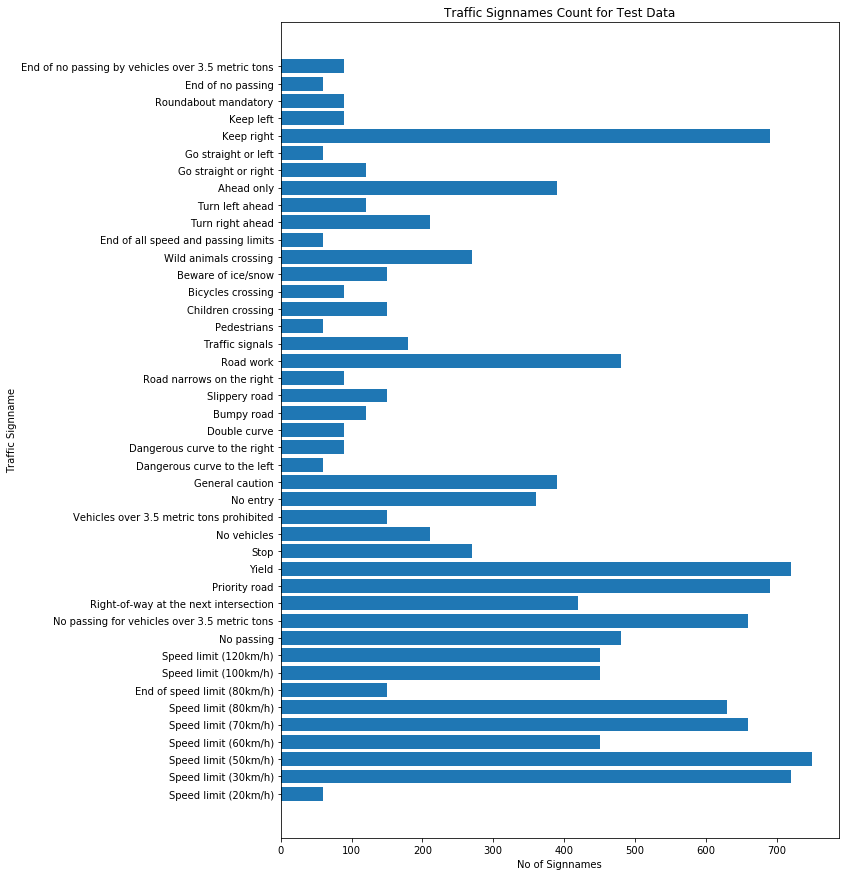

In [7]:
# 4. Display Test Dataset Sign Counts in Distribution Bar Graph
plt.figure(figsize=(10,15))
plt.barh(classes, test_unique_counts)
plt.xlabel('No of Signnames', fontsize=10)
plt.ylabel('Traffic Signname', fontsize=10)
plt.yticks(classes, sign_dict.values(), fontsize=10)
plt.title('Traffic Signnames Count for Test Data')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Preprocess the Dataset (normalization, data augmentation)

In [8]:
import cv2

# normalize_images function normalizes image pixel values between -0.5, 0.5
def normalize_images(images):
    norm_images = []
    for image in images:
        norm_img = (image / 255.0) - 0.5
        norm_images.append(norm_img)
    return norm_images

# normalization applied to the training, validation and testing set
X_train = normalize_images(X_train)
X_valid = normalize_images(X_valid)
X_test = normalize_images(X_test)

# data augmentation function uses rotations on the images from -15 to +15 degrees 
# augmenting the data using rotations helps the model to learn recognize traffic
# signs in multiple orientations
def augment_data(images, labels):
    # initialize labels
    image_labels = []
    # initialize augmented data
    augmented_images = []
    # initialize rotate image parameters
    rotated_image = None
    (h, w) = images[0].shape[:2]
    center = (w/2, h/2)
    rot_angles = [-15, -10, -5, 5, 10, 15]
    scale = 1.0
    for image, label in zip(images, labels):
        # rotated image: loop 0 to 5 to save all rotation ops
        for rot_angle in rot_angles:
            # rotate image randomly: -15 to +15 degrees
            M = cv2.getRotationMatrix2D(center, rot_angle, scale)
            rotated_image = cv2.warpAffine(image, M, (w, h))
            # add same label from original image to new rotated image
            augmented_images.append(rotated_image)
            image_labels.append(label) 
    return augmented_images, image_labels

# Replace existing training dataset with augmented training dataset
augmented_data, augmented_labels = [], []
augmented_data, augmented_labels = augment_data(X_train, y_train)
X_train = augmented_data
n_aug_train = len(X_train)
print("Number of augmented training examples =", n_aug_train)
y_train = augmented_labels

Number of augmented training examples = 208794


In [9]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Build the Model Architecture (LeNet-5)

In [10]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 64

from tensorflow.contrib.layers import flatten

# Define LeNet architecture using TensorFlow
def LeNet(x, keep_prob):   
    global conv1
    global conv2
    # Arguments used for tf.truncated_normal, 
    # randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x64.
    # The formula for convolutions tell us:
    # out_h = (in_h - filter_h + 1)/strides[1]
    # out_w = (in_w - filter_w + 1)/strides[2]
    # this layer has a 3x3 filter with in_depth 3 and out_depth 64
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,64), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(64))
    # we use conv2d to convolve the filter over the imgs and add bias at end
    conv1 = tf.nn.conv2d(x, conv1_W, strides = [1,1,1,1], padding = 'VALID') + conv1_b

    # Relu Activation.
    # we activate the conv1 of the convolutional layer with relu activation function
    conv1 = tf.nn.relu(conv1, name='conv1_relu')
    
    # Max Pooling. Input = 28x28x64. Output = 14x14x64.
    # we pool the conv1 using 2x2 kernel with 2x2 stride
    # filter size = 2x2
    # moves at stride of 2
    # out_h = (in_h - filter_h)/S + 1
    # out_w = (in_w - filter_w)/S + 1
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', name='conv1_pool')
    
    # the network then runs through another set of convolutional, 
    # activation and pooling layers outputting 5x5x32
    
    # Layer 2: Convolutional. Input = 14x14x64 Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,64,32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    # move at stride of 1
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding = 'VALID') + conv2_b
    
    # Relu Activation.
    conv2 = tf.nn.relu(conv2, name='conv2_relu')
    
    # Max Pooling. Input = 10x10x16. Output = 5x5x32.
    # filter size = 2
    # moves at stride of 2
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', name='conv2_pool')  
    
    # Flatten. Input = 5x5x32. Output = 800.
    # we flatten this output into a vector, the length of the vector =  5x5x32 = 800.
    fc0 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 800. Output = 120.
    # we pass this vector into a fully connected layer with a width of 120
    # shape=(height, width)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800,120), mean = mu, stddev = sigma))
    # tf.zeros(120) is 1D array with 120 elements that are 0
    fc1_b = tf.Variable(tf.zeros(120))
    # x*W + b
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Relu Activation.
    # then we apply relu to the output of the fc1
    fc1 = tf.nn.relu(fc1)

    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # we repeat the fc again with width of 84
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    # x*W + b
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Relu Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    # finally we attach a fc output layer with a width equal to the number of classes in our label set
    # in this case, we have 43 classes, one for each traffic sign
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84,43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    # x*W + b
    # these outputs are also known as our logits, which is what we return from our lenet function
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Set the TensorFlow Placeholders for Features and Labels

In [11]:
# set x, the batch of input imgs to none, which will allow the placeholder to 
# later accept a batch of any size
# img dimensions are set to 32x32x3. output depth is 3 since image is rgb. (1 if grayscale image)
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
# y stores our labels, our labels come through as sparse variables, they are ints they aren't one hot encoded yet
y = tf.placeholder(tf.int32, (None))
# we use tf.one_hot function to one hot encode the labels
one_hot_y = tf.one_hot(y, 43)
# probability to keep units
keep_prob = tf.placeholder(tf.float32) 

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training Pipeline

Create a training pipeline that uses the model to classify GTSRB data

In [12]:
# we have another hyperparameter, learning rate tells tensorflow how quickly to update the networks weights
rate = 0.001
# we pass the input data to LeNet function to calculate our logits
logits = LeNet(x, keep_prob)
# we use the softmax cross entropy function to compare those logits to the ground truth labels
# and calculate the cross entropy. Cross entropy is a measure of how different the logits are
# from the ground truth labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# The tf.reduce_mean function averages the cross entropy from all the training images
loss_operation = tf.reduce_mean(cross_entropy)
# Adam optimizer uses the Adam algorithm to minimize the loss function
# Similar to the stochastic gradient descent, Adam is a little more sophisticated than it
# this is where we use the learning rate hyperparameter set earlier
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# finally we use minimize function on the optimizer, which uses backpropagation to update the network
# and minimize our training loss
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Training and Evaluating the Model using Training and Validation Set

Train the model over 10 epochs using the GTSRB dataset. At the start of each epoch, shuffle our
training data, then break our training data into 64 batches and train the model on each batch.
After each epoch, calculate the model's accuracy on the training and then validation set using the evaluate() function. Save the model once it has been completely trained.

In [13]:
# Evaluation pipeline evaluates how good the model is

# the below two functions are the entire evaluation pipeline, but in order to run this
# evaluation pipeline, we built an evaluate function

# the first step in this pipeline is to measure whether a given prediction is correct
# by comparing the logit prediction to the one hot encoded ground truth label
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

# the second step is to calculate the model's overall accuracy by averaging the individual
# prediction accuracies
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# this function takes a dataset as input, sets some initial variables
# then batches the dataset and runs it through the evaluation pipeline
# the evaluate function averages the accuracy of each batch to calculate the total
# accuracy of the model
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# now everything is setup, we built a function to train and evaluate our model
# first we created the tensorflow session and initialized the variables
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    # train over whatever number has been set in the EPOCHS hyperparameter
    print("Training...")
    print()
    for i in range(EPOCHS):
        # at the beginning of each EPOCH, shuffle our training data to ensure that our training isn't bias
        # by the order of the images
        X_train, y_train = shuffle(X_train, y_train)
        # then break our training data into batches and train the model on each batch
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        # at the end of each EPOCH, evaluate the model on our training data
        train_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))           
            
        # at the end of each EPOCH, evaluate the model on our validation data
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    # once we have completely trained the model, save it, so we can load it up later and modify it
    # or evaluate the model on our test dataset
    saver.save(sess, './lenet_model')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.967
Validation Accuracy = 0.936

EPOCH 2 ...
Train Accuracy = 0.983
Validation Accuracy = 0.954

EPOCH 3 ...
Train Accuracy = 0.993
Validation Accuracy = 0.962

EPOCH 4 ...
Train Accuracy = 0.995
Validation Accuracy = 0.970

EPOCH 5 ...
Train Accuracy = 0.996
Validation Accuracy = 0.972

EPOCH 6 ...
Train Accuracy = 0.996
Validation Accuracy = 0.967

EPOCH 7 ...
Train Accuracy = 0.997
Validation Accuracy = 0.980

EPOCH 8 ...
Train Accuracy = 0.998
Validation Accuracy = 0.963

EPOCH 9 ...
Train Accuracy = 0.998
Validation Accuracy = 0.972

EPOCH 10 ...
Train Accuracy = 0.997
Validation Accuracy = 0.969

Model saved


### Evaluating the Model using Testing Set

Once we are completely satisfied with the model's validation accuracy, we evaluate the performance of the model on the testing set. I only evaluated the model on the test set once to get a good
estimate of how well the model would perform in the real world.

In [14]:
### Once a final model architecture is selected, 
### the accuracy on the test set is calculated and reported.

# we evaluate the model on our test dataset
# we only run the model on the test dataset one time once we are completely done with training
# otherwise we would use the test dataset to choose the best model and then the test dataset wouldn't
# provide a good estimate of how well the model would do in the real world

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from .\lenet_model
Test Accuracy = 0.962


---

## Step 3: Test a Model on New Images

I downloaded at least five pictures of German traffic signs from the web and used the model to predict the traffic sign type to see how well the model is working.

I also found the `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

assets/data/images/web_gts\50km_speed_limit.jpg
50km_speed_limit.jpg
assets/data/images/web_gts\children_crossing.jpeg
children_crossing.jpeg
assets/data/images/web_gts\no_entry.jpg
no_entry.jpg
assets/data/images/web_gts\priority_road.jpg
priority_road.jpg
assets/data/images/web_gts\road_work.jpg
road_work.jpg
uint8
uint8
uint8
uint8
uint8


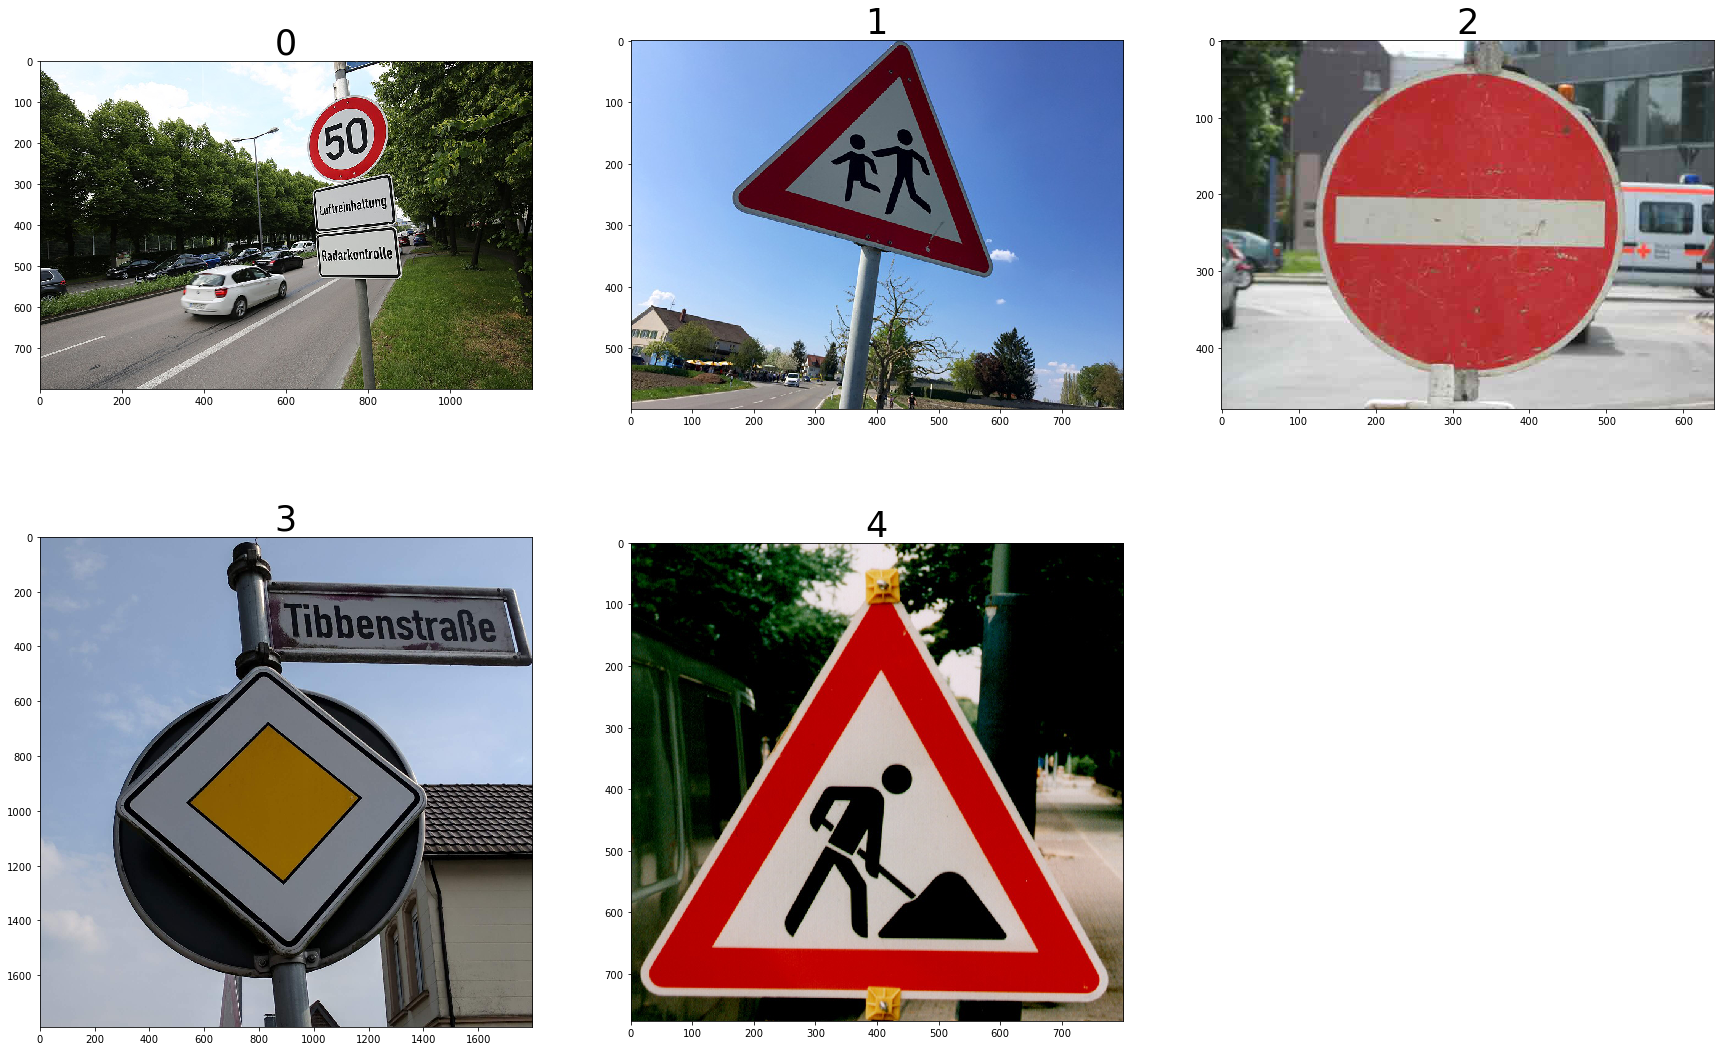

In [15]:
import sys
import glob
import matplotlib.image as mpimg

# Download at least 5 pictures of German traffic signs from the web
# Street view of germany in google maps
X_test_web = []
filenames = []
files = glob.glob('assets/data/images/web_gts/*')
for file in files:
    print(file)
    if sys.platform == 'win32':
        filename = file.split('\\')[-1]
    elif sys.platform == 'linux':
        filename = file.split('/')[-1]
    print(filename)
    filenames.append(filename)
    image = mpimg.imread(file)
    X_test_web.append(image)

n_web_images = len(X_test_web)

# increasing col, increases size of images in subplot. col = 60
fig = plt.figure(figsize=(30,20))
fig.subplots_adjust(hspace = 0.05, wspace = 0.2)
nrows = math.ceil(n_web_images/3) # 2 rows
ncols = math.ceil(n_web_images/2) # 3 columns
# Plot the web images
for i in range(n_web_images):
    sub = fig.add_subplot(nrows, ncols, i + 1)
    image = X_test_web[i]
    print(image.dtype)
    sub.set_title(i, size=35)
    sub.imshow(image, interpolation = 'nearest')

### Preprocess Web Image Scale to 32x32

(32, 32, 3)
uint8
uint8
uint8
uint8
uint8


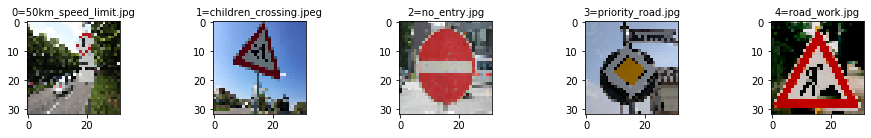

In [16]:
img_size = 32

# Scale web images 32x32x3
def scale_images(images, image_size):
    resize_images = []
    for image in images:
        resize_image = cv2.resize(image, (image_size, image_size))
        resize_images.append(resize_image)
    return resize_images

# preprocess to the size our network needs
X_test_web_orig = list(X_test_web)
X_test_web = scale_images(X_test_web, img_size)

print(X_test_web[0].shape)

# increasing width, increases spacing between images in each row
# increasing row, increases spacing between images in each column
# width, height
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace = 0.05, wspace = 1)
# fig.subplots_adjust(hspace = 0.5, wspace = 1)
nrows = math.ceil(n_web_images/5) # 1 row
ncols = math.ceil(n_web_images/1) # 5 columns
# Plot the resized web images
for i in range(n_web_images):
    sub = fig.add_subplot(nrows, ncols, i + 1)
    image = X_test_web[i]
    print(image.dtype)
    sub.set_title(str(i) + '=' + filenames[i], size=10)
    sub.imshow(image, interpolation = 'nearest')

### Normalize Images, Ensure Pixel [-0.5,0.5]

In [17]:
# data preprocessing done by tensorflow model normalization applied
X_test_web = normalize_images(X_test_web)

# Predict the Sign Type for Each Image

In [18]:
# Return the index with the largest value in a two dimensional array (tensor), which
# is the class ID prediction
prediction = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: X_test_web, keep_prob: 1.0})
    
print("\nLogits Prediction Result:")
for p_i in predictions:
    print("prediction = %d, sign name = %s" %(p_i, sign_dict[p_i]))


INFO:tensorflow:Restoring parameters from .\lenet_model

Logits Prediction Result:
prediction = 40, sign name = Roundabout mandatory
prediction = 26, sign name = Traffic signals
prediction = 17, sign name = No entry
prediction = 12, sign name = Priority road
prediction = 25, sign name = Road work


### Analyze Performance

In [19]:
### Calculate the accuracy for these 5 new images. 
# accuracy = # correct / total images
# extract class ID: sign name as key:value pair into dictionary
web_sign_dict = {}
with open("assets/data/images/web_signnames.csv") as signnames_file:
    reader = csv.reader(signnames_file)
    # Skip the first row of the csv file
    next(reader)    
    for rows in reader:
        web_sign_dict[int(rows[1])] = rows[2]

web_sign_label = list(web_sign_dict.keys())

# total number of correct predictions
sum = 0
# CNN model's accuracy for classifying 5 traffic sign images
accuracy = 0

# find the number of times the model predicted the traffic sign correctly, then divide that by the
# total number of signs to get the accuracy for web images.
for i in range(n_web_images):
    if web_sign_label[i] == predictions[i]:
        sum += 1
accuracy = sum/n_web_images
print("Web Test Accuracy = %.2f" %(accuracy))

Web Test Accuracy = 0.60


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) was helpful here. 

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

INFO:tensorflow:Restoring parameters from .\lenet_model

Top 5 Softmax Probabilities For Each Image:


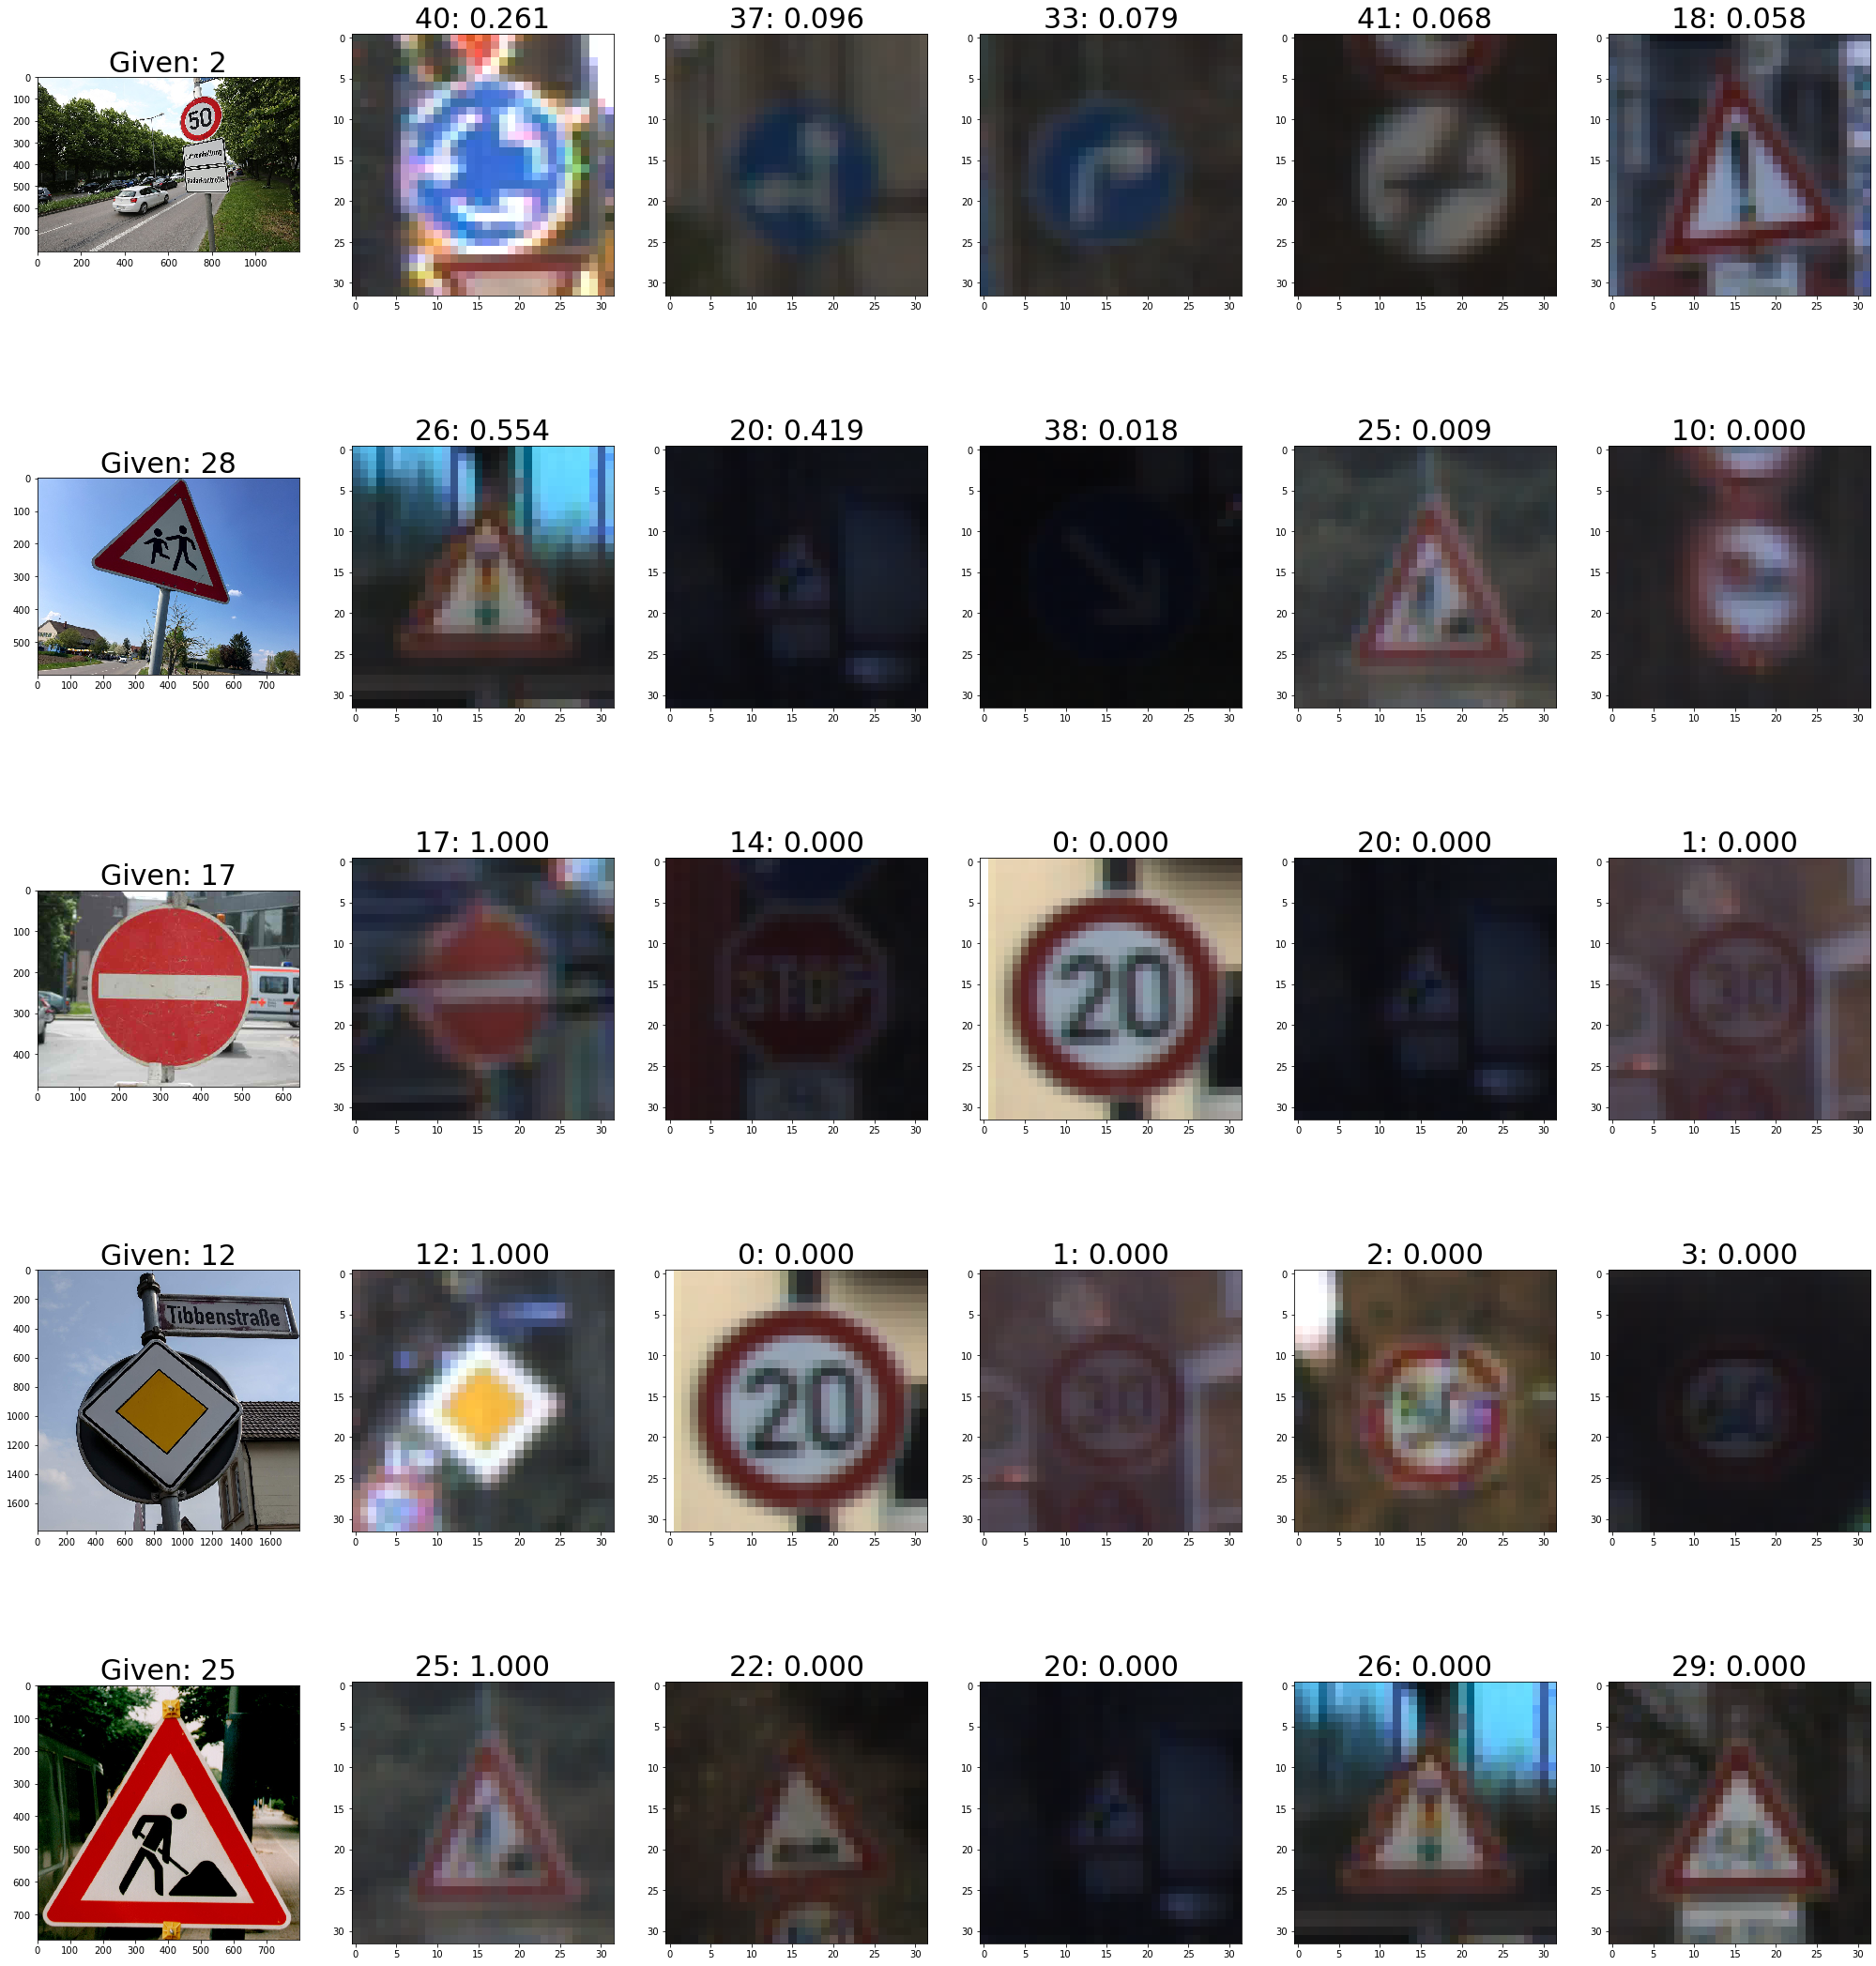

In [20]:
### Print the top five softmax probabilities for the predictions on the German traffic sign 
# images found on the web. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top5_kv = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), {x: X_test_web, keep_prob: 1.0})
    
# Web Image Gallery shows the Top 5 Softmax Probabilities    
top5_pred_list, top5_classIds_list = top5_kv
print("\nTop 5 Softmax Probabilities For Each Image:")
nrows = 5 # 5 rows
ncols = 6 # 6 columns
fig, axs = plt.subplots(nrows, ncols,figsize=(35,40))
fig.subplots_adjust(hspace = 0.05, wspace = 0.2)
for i in range(len(X_test_web_orig)):
    classIds = top5_classIds_list[i]
    preds = top5_pred_list[i]
    given_image = X_test_web_orig[i]
    j = 0
    axs[i, j].imshow(given_image)
    title1 = "Given: {}".format(web_sign_label[i])
    axs[i, j].set_title(title1, size=30)
    for j in range(1, len(classIds)+1):
        pred_image = X_train_orig[indices[classIds[j-1]]]
        axs[i, j].imshow(pred_image)
        title2 = "{}: {:.3f}".format(classIds[j-1], preds[j-1])
        axs[i, j].set_title(title2, size=30)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4: Visualize Layers of the Neural Network with Web Images

I visualized the feature maps from multiple layers of LeNet to better understand what the weights of the neural netowrk look like. In addition, I also tried to see what characteristics of a traffic sign image the network finds interesting.

INFO:tensorflow:Restoring parameters from .\lenet_model
Convolution Layer 1: 64 Features
Convolution Layer 2: 32 Features


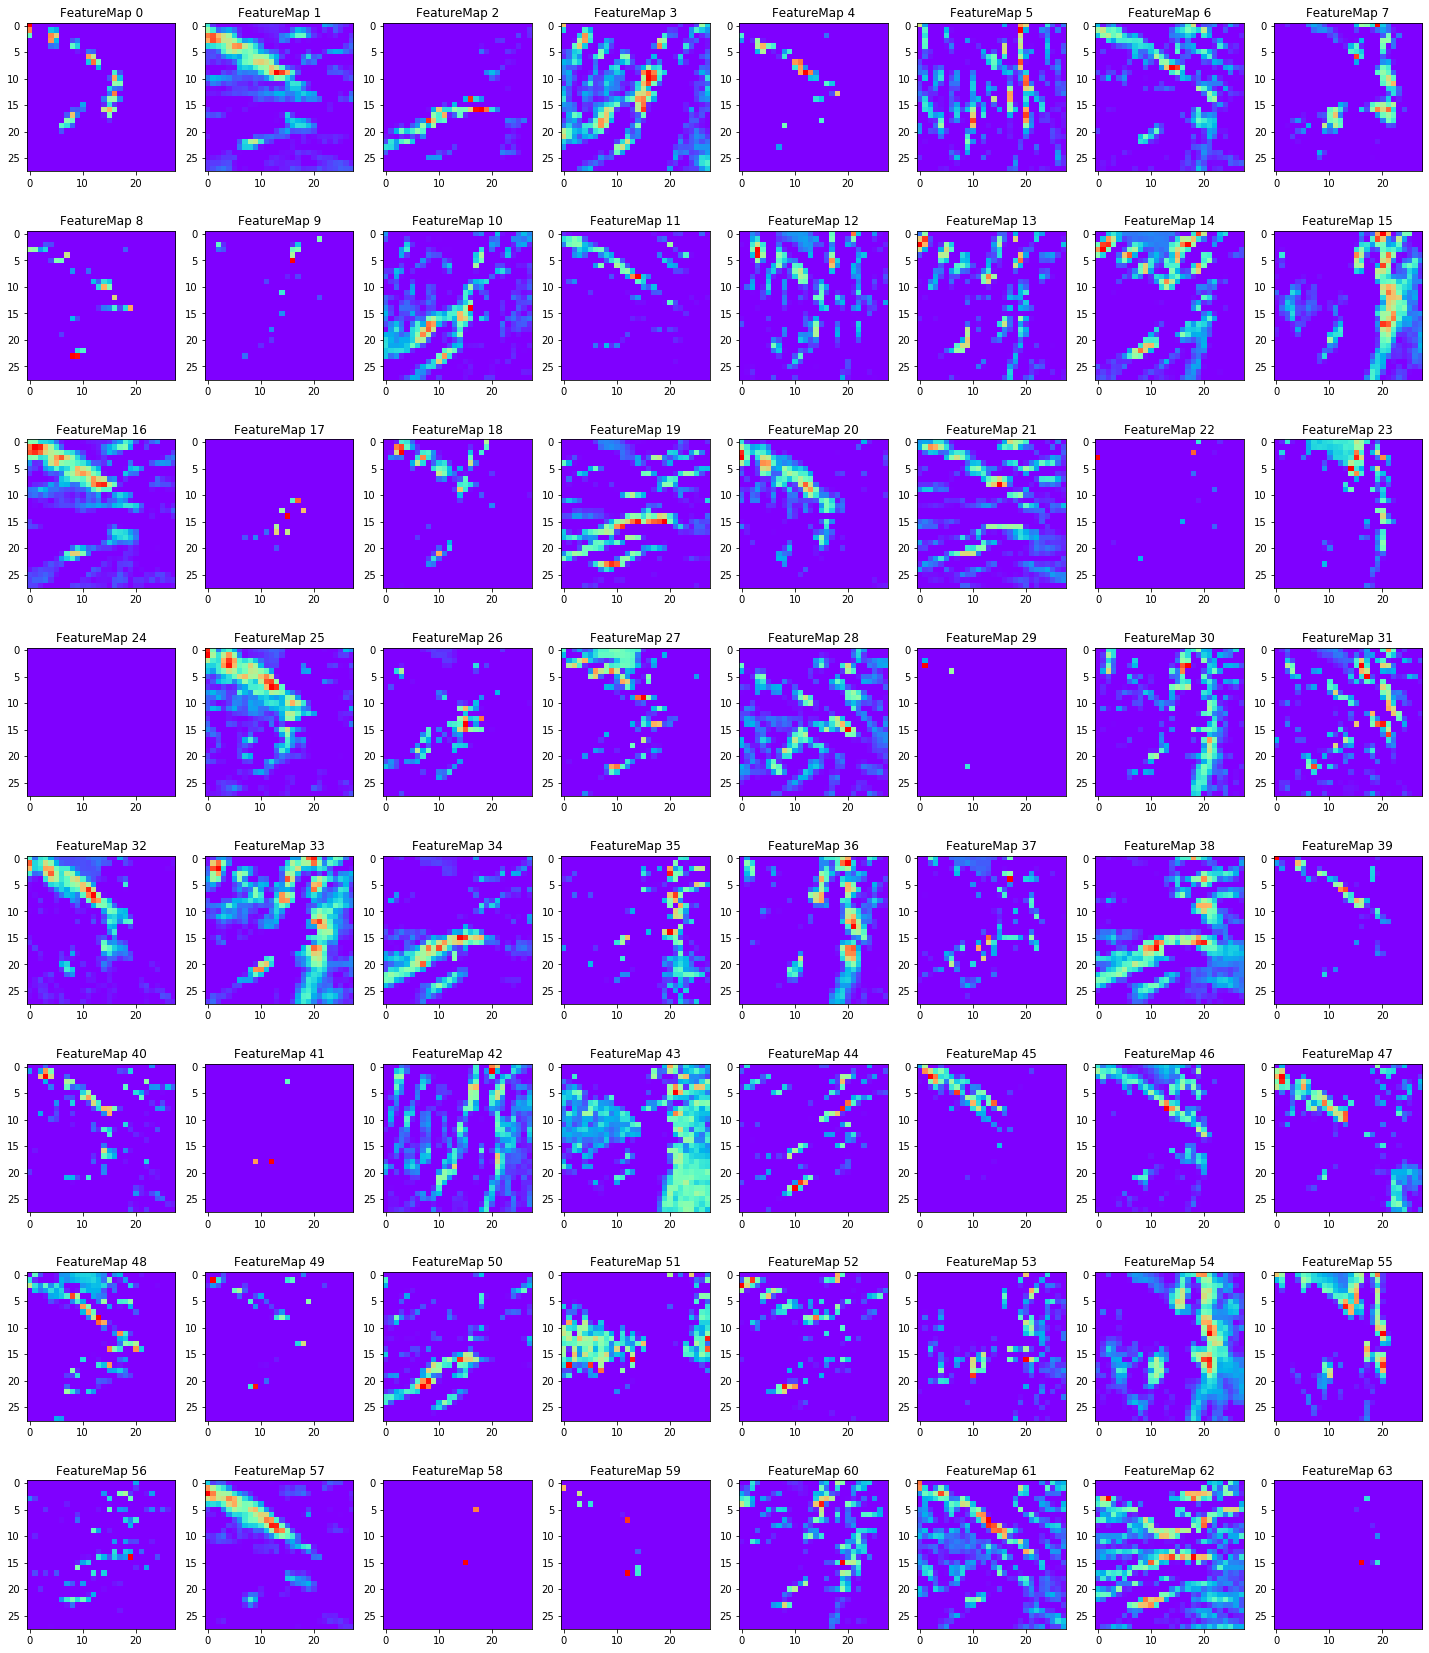

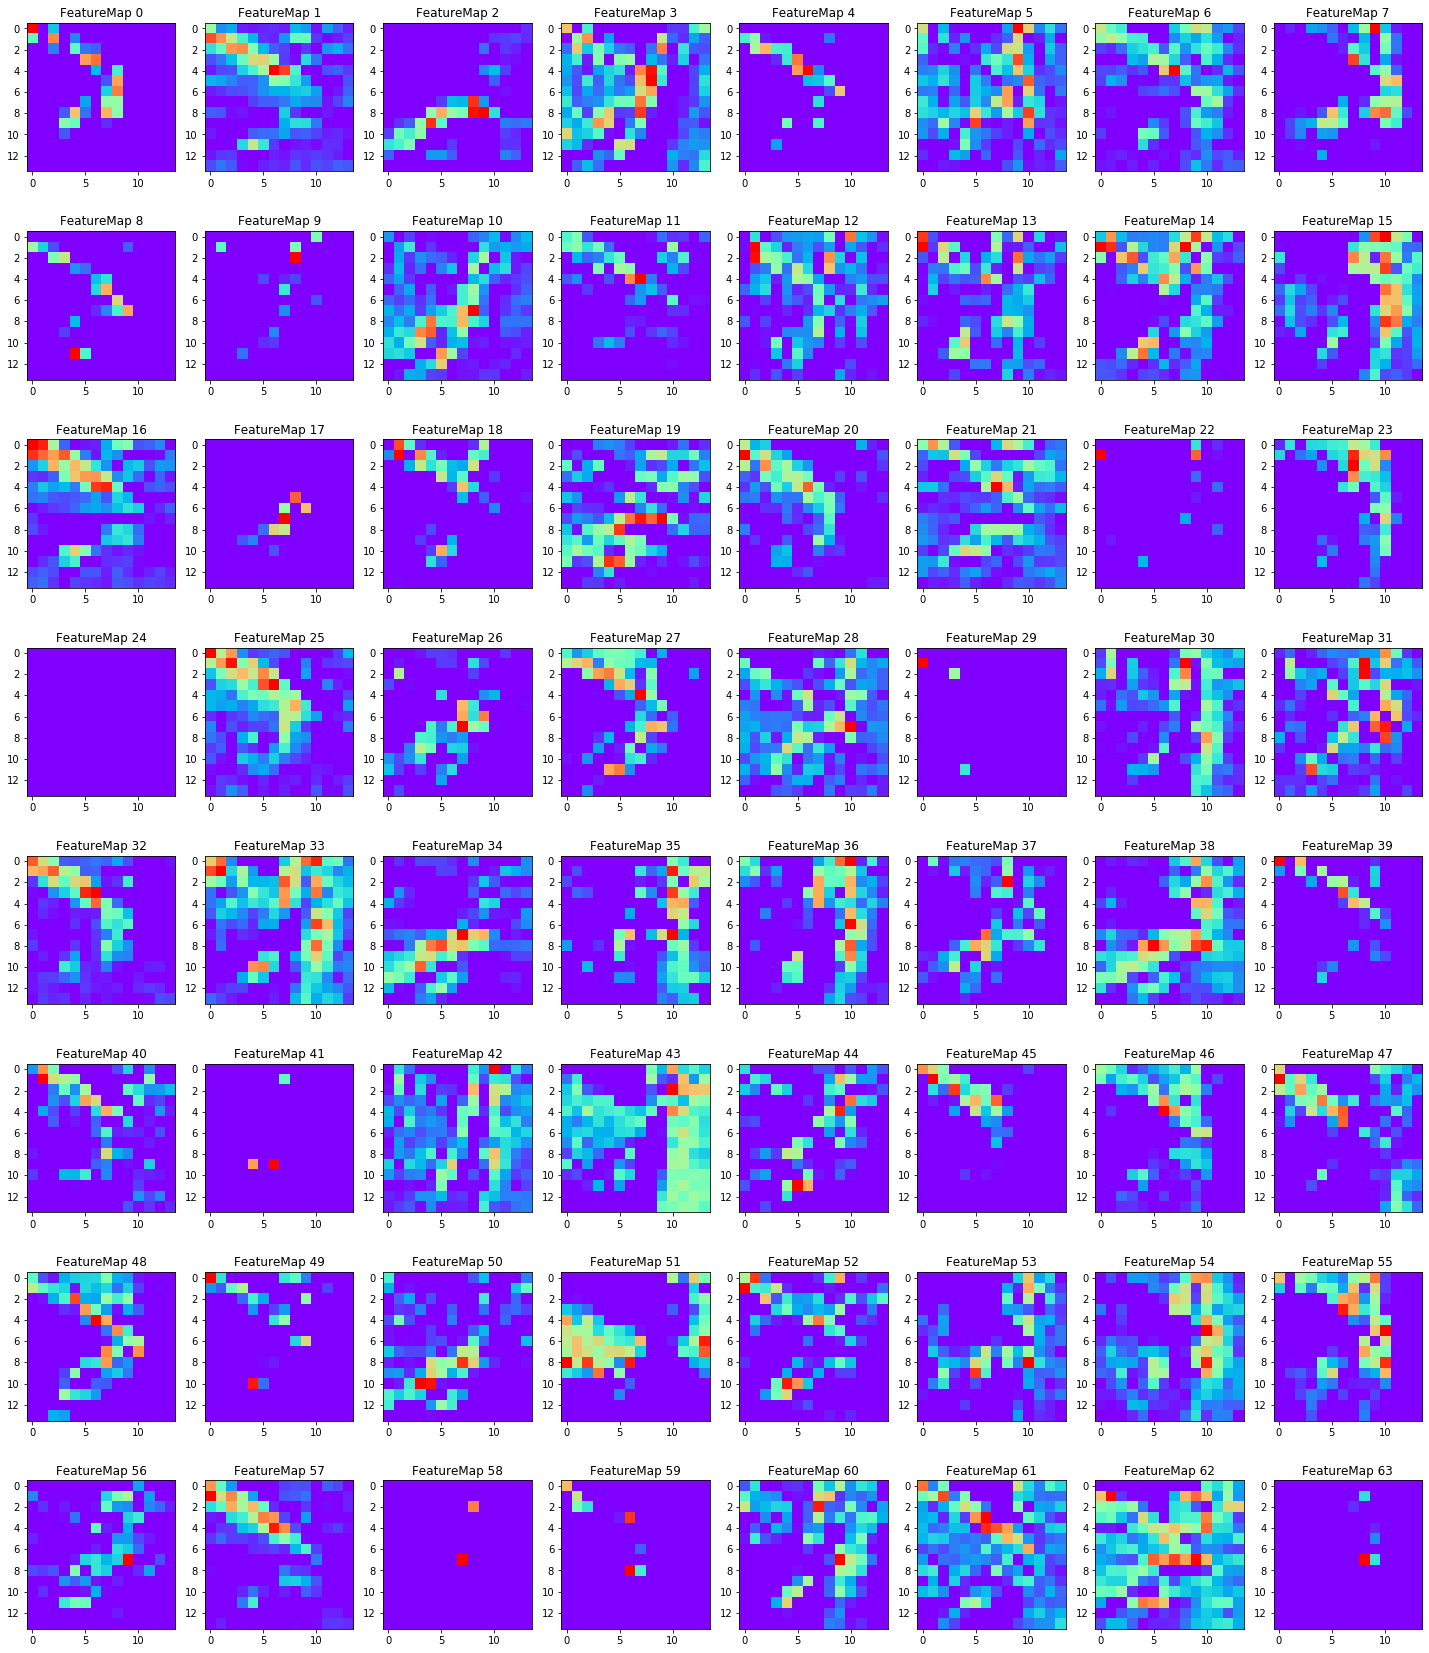

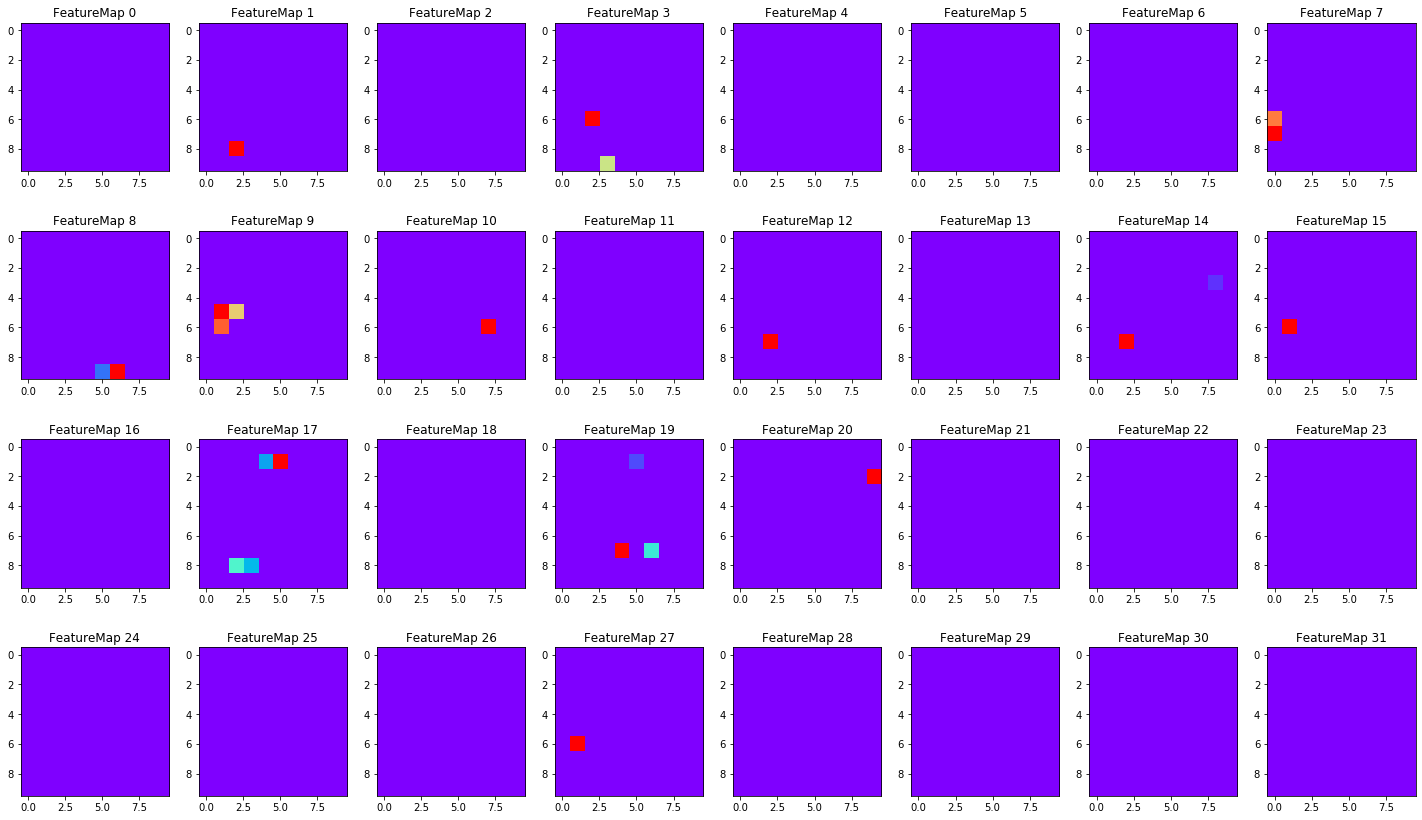

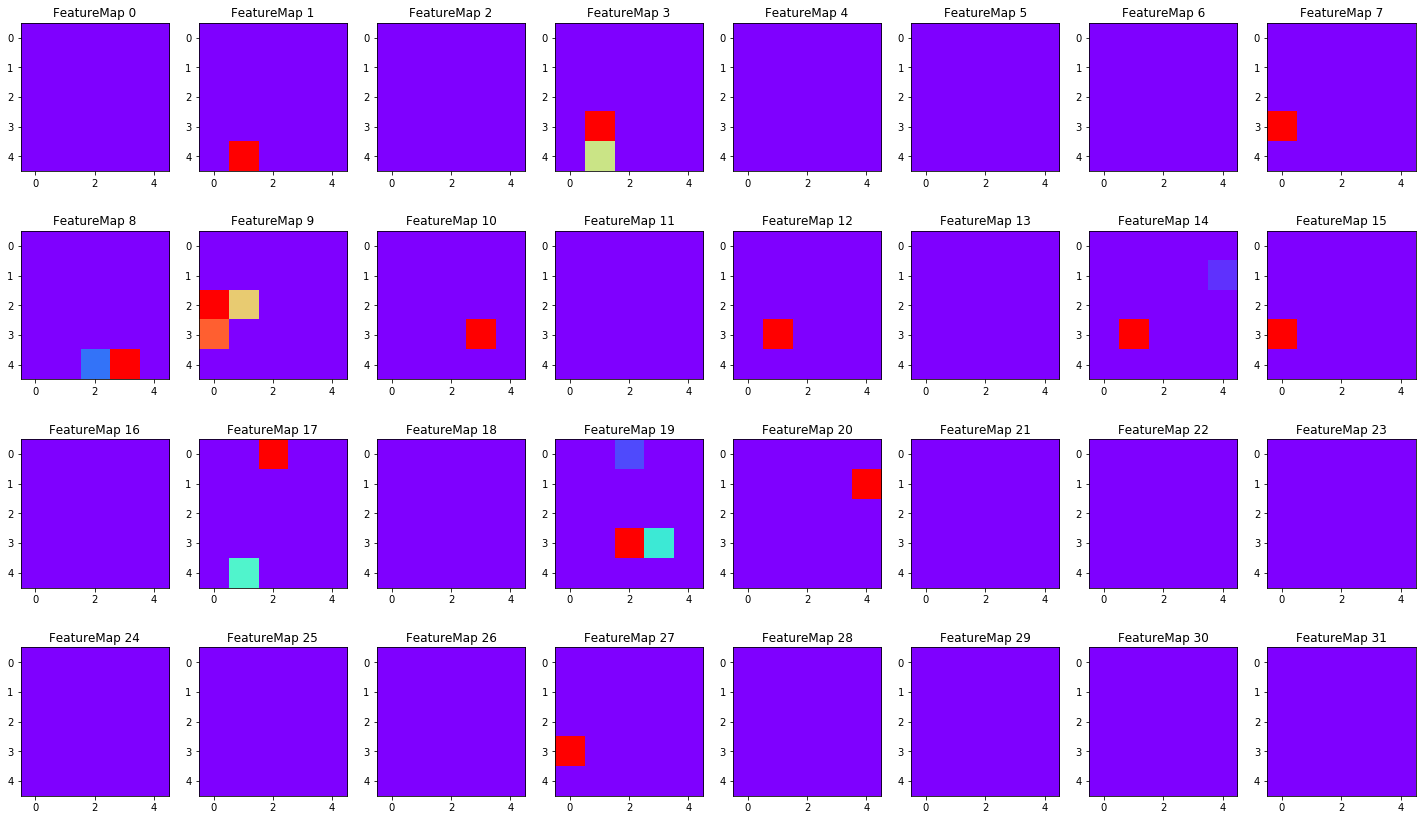

In [21]:
### Visualize your network's feature maps

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(25,30))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="rainbow")
            
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Convolution Layer 1: 64 Features")
    print("Convolution Layer 2: 32 Features")
    conv1_relu = sess.graph.get_tensor_by_name('conv1_relu:0')
    outputFeatureMap(X_test_web, conv1_relu, plt_num=1)
    
    conv1_pool = sess.graph.get_tensor_by_name('conv1_pool:0')
    outputFeatureMap(X_test_web, conv1_pool, plt_num=2)

    conv2_relu = sess.graph.get_tensor_by_name('conv2_relu:0')
    outputFeatureMap(X_test_web, conv2_relu, plt_num=3)
    
    conv2_pool = sess.graph.get_tensor_by_name('conv2_pool:0')
    outputFeatureMap(X_test_web, conv2_pool, plt_num=4)    
    